In [1]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import numpy as np
import pandas as pd
from pyomo.environ import *
from GPy.kern import RBF
from GPy.kern import Matern52
from GPy.kern import Linear
from datetime import datetime
import time
import os
import textwrap
import re
import inspect
import matplotlib.pyplot as plt

In [2]:
start_time = datetime.fromtimestamp(time.time())

data_path = r'DataSet\siouxdata\\'

candid = pd.read_excel(data_path + 'candidpoint.xlsx', sheet_name='Sheet1')
deltalink = pd.read_excel(data_path + 'deltalinksioux.xlsx', sheet_name='Sheet1')
facilitycap = pd.read_excel(data_path + 'capfacsioux.xlsx', sheet_name='Sheet1')
nodedem = pd.read_excel(data_path + 'demandsioux.xlsx', sheet_name='Sheet1')
linkcap = pd.read_excel(data_path + 'caplinknsioux.xlsx', sheet_name='Sheet1')
linkfreecost = pd.read_excel(data_path + 'freeflownsioux.xlsx', sheet_name='Sheet1')
qod = pd.read_excel(data_path + 'xodsioux.xlsx', sheet_name='Sheet1')   
numod = pd.read_excel(data_path + 'numodsioux.xlsx', sheet_name='Sheet1')
deltaod = pd.read_excel(data_path + 'deltaodsioux.xlsx', sheet_name='Sheet1')
fixedfacility = pd.read_excel(data_path + 'fixedcostsioux.xlsx', sheet_name='Sheet1')
capincreas=0.1 * pd.read_excel(data_path + 'caplinknsioux.xlsx', sheet_name='Sheet1')

end_time = datetime.fromtimestamp(time.time())

# --- Stop conditions
max_time  = 1000
max_iter  = 100
tolerance = 0 #1e-2

print('Total time for read data: ', end_time - start_time)

Total time for read data:  0:00:10.532999


In [3]:
[numlink,numpath]=np.shape(deltalink)
(a,numfacility)=np.shape(facilitycap)
(b,numcustomer)=np.shape(nodedem)
# sets
Model.setpath = range(numpath)
Model.setfacility = range(numfacility)
Model.setcustomer = range(numcustomer)
Model.setlink = range(numlink)
print('numpath', numpath, '\nnumlink: ', numlink, '\nnumfacility: ', numfacility)

numpath 940 
numlink:  100 
numfacility:  12


In [4]:
def objfunc2d(x):
    
    Model = AbstractModel()
    xe=np.zeros(([1,numlink]))
    y=np.zeros(([1,numfacility]))
    for k in Model.setlink:
        xe[0,k]=x[:,k]
            
    print(xe)
    Model._fprimrsk = Var(Model.setpath,within=NonNegativeReals)
    Model._ve = Var(Model.setlink,within=NonNegativeReals)
    
    def fobjective(Model):
        return sum(linkfreecost.iloc[0,e]*(Model._ve[e]+0.15*Model._ve[e]**5/
                                               (5*((linkcap.iloc[0,e]+xe[0,e]*capincreas.iloc[0,e])**4))) for e in Model.setlink)
    Model.obj = Objective(rule=fobjective,sense=minimize)

    def cons4(Model,r,s):
        return sum(Model._fprimrsk[k]*deltaod.iloc[numod.iloc[r,s]-1,k]  for k in Model.setpath)==qod.iloc[r,s]
    Model.con4 = Constraint(Model.setcustomer,Model.setcustomer,rule=cons4)
 
    def cons5(Model,e):
        return sum((Model._fprimrsk[k])*deltalink.iloc[e,k]  for k in Model.setpath) ==Model._ve[e]
    Model.con5=Constraint(Model.setlink,rule=cons5) 
        
    NTA0 = Model.create_instance()
    
    opt = SolverFactory('ipopt')
    opt.solve(NTA0)
    return sum(linkfreecost.iloc[0,e]*(1*NTA0._ve[e].value+0.15*NTA0._ve[e].value**5/
                                               (((linkcap.iloc[0,e]+xe[0,e]*capincreas.iloc[0,e])**4))) for e in Model.setlink)

## Here define constraints into function

In [5]:
def constraint_to_string(constraint_function):
    source_code = inspect.getsource(constraint_function)    
    # Remove whitespaces and indentation
    source_code = textwrap.dedent(source_code)    
    # Extract the constraint expression
    constraint_expression = re.search(r'return\s+(.*)(\s)*$', source_code, re.MULTILINE).group(1)    
    return constraint_expression

bounds = [{'name': 'xe', 'type': 'discrete', 'domain': (0,1), 'dimensionality':numlink}]

## RBF kernel 30

In [6]:
# Budget constraint function
def budget_constraint(x):
    return sum(x[:, e] for e in range(100)) - 30

constraint_string = constraint_to_string(budget_constraint)
constraints30 = [{'name': 'budget_con', 'constraint': constraint_string}]

In [7]:
start_time = datetime.fromtimestamp(time.time())

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space=bounds, constraints=constraints30) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True, optimize_restarts=5, verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Create BO object
bo_rbf30 = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

# Run the optimization                                                  
bo_rbf30.run_optimization(max_iter=max_iter, max_time=max_time, eps=tolerance, verbosity=False) 

end_time = datetime.fromtimestamp(time.time())
print('Total time for rbf kernel 30 edges: ', end_time - start_time)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.
  0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 1.]]
[[0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
  1. 0. 0. 1.]]
[[0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1.
  0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.

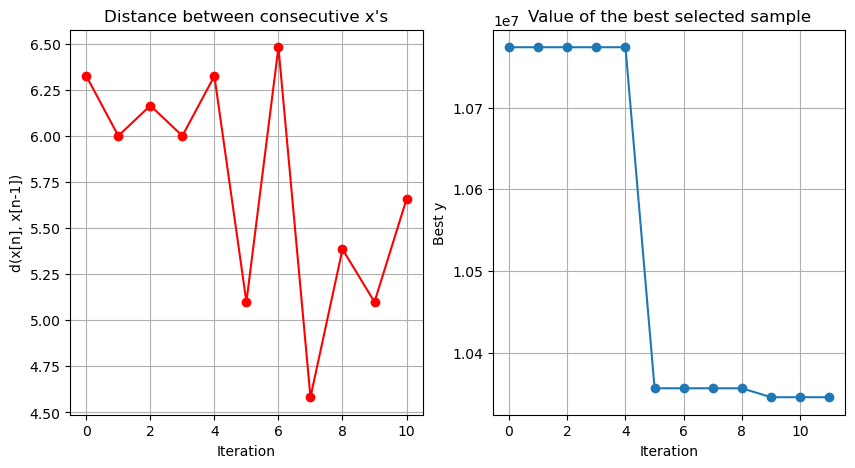

In [8]:
bo_rbf30.plot_convergence()

In [9]:
print(bo_rbf30.x_opt)
print(bo_rbf30.fx_opt)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 1.]
10346082.637847604


In [10]:
# for 30 dim = 10422201.02
# جواب یک سطحی: 
# هجده میلیون و سیصد و هشتاد و پنج هزار و یكصد و هشتاد و نه
# جواب دو سطحی:
# ده میلیون و چهارصد و هفتاد و دو هزار و پانصد و سی و چهار

## RBF kernel 35

In [11]:
# Budget constraint function
def budget_constraint(x):
    return sum(x[:, e] for e in range(100)) - 35

constraint_string = constraint_to_string(budget_constraint)
constraints35 = [{'name': 'budget_con', 'constraint': constraint_string}]

In [12]:
start_time = datetime.fromtimestamp(time.time())

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space=bounds, constraints=constraints35) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True, optimize_restarts=5, verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Create BO object
bo_rbf35 = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

# Run the optimization                                                  
bo_rbf35.run_optimization(max_iter=max_iter, max_time=max_time, eps=tolerance, verbosity=False) 

end_time = datetime.fromtimestamp(time.time())
print('Total time for rbf kernel 35 edges: ', end_time - start_time)

[[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
  0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0.]]
[[1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
  0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
  1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1.
  1. 0. 0. 0.]]
[[0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
  0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.

[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
  1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.
  1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1.
  0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1.
  0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1.
  1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0.
  0. 1. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.
  1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 1.]]
[[0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.

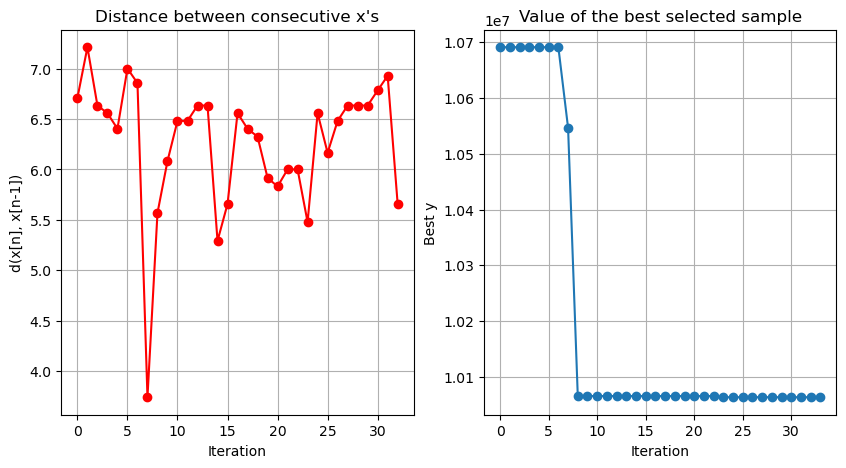

In [13]:
bo_rbf35.plot_convergence()

In [14]:
print(bo_rbf35.x_opt)
print(bo_rbf35.fx_opt)

[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0.]
10063644.56459862


## RBF kernel 40

In [15]:
# Budget constraint function
def budget_constraint(x):
    return sum(x[:, e] for e in range(100)) - 40

constraint_string = constraint_to_string(budget_constraint)
constraints40 = [{'name': 'budget_con', 'constraint': constraint_string}]

In [16]:
start_time = datetime.fromtimestamp(time.time())

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space=bounds, constraints=constraints40) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True, optimize_restarts=5, verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Create BO object
bo_rbf40 = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

# Run the optimization                                                  
bo_rbf40.run_optimization(max_iter=max_iter, max_time=max_time, eps=tolerance, verbosity=False) 

end_time = datetime.fromtimestamp(time.time())
print('Total time for rbf kernel 40 edges: ', end_time - start_time)

[[1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
  0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
  0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 1. 0.]]
[[0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
  1. 0. 0. 0.]]
[[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0.
  1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
  0. 1. 0. 1.]]
[[0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1.

[[0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1.
  0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
  1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
  0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
  0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0.
  1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.
  0. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
  1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1.
  0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1.
  1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
  0. 1. 1. 1.]]
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0.

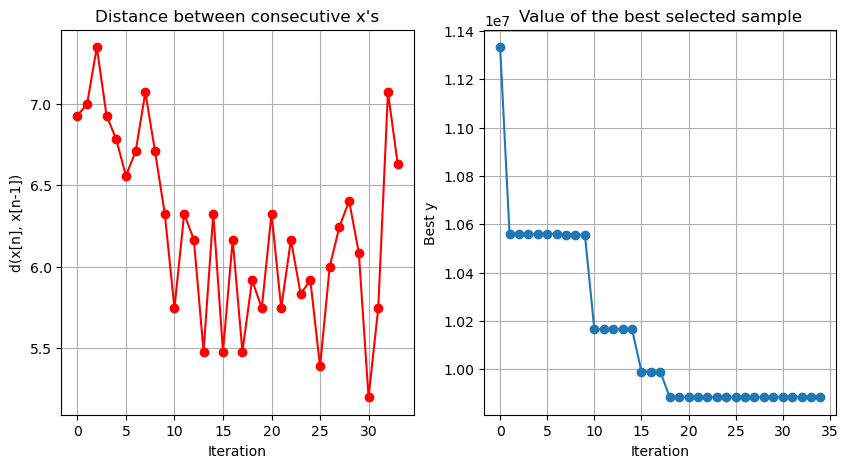

In [17]:
bo_rbf40.plot_convergence()

In [18]:
print(bo_rbf40.x_opt)
print(bo_rbf40.fx_opt)

[0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0.]
9883833.022703405


## RBF kernel 45

In [19]:
# Budget constraint function
def budget_constraint(x):
    return sum(x[:, e] for e in range(100)) - 45

constraint_string = constraint_to_string(budget_constraint)
constraints45 = [{'name': 'budget_con', 'constraint': constraint_string}]

In [20]:
start_time = datetime.fromtimestamp(time.time())

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space=bounds, constraints=constraints45) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True, optimize_restarts=5, verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Create BO object
bo_rbf45 = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

# Run the optimization                                                  
bo_rbf45.run_optimization(max_iter=max_iter, max_time=max_time, eps=tolerance, verbosity=False) 

end_time = datetime.fromtimestamp(time.time())
print('Total time for rbf kernel 45 edges: ', end_time - start_time)

[[1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1.
  0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.
  0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1.
  1. 0. 0. 1.]]
[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1.
  0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0.]]
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
  0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0.
  1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
  1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1.
  1. 0. 1. 0.]]
[[1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.

[[1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0.
  1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0.
  0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
  0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
  1. 0. 1. 0.]]
[[0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
  0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0.
  0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
  0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.
  0. 1. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
  1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1.
  0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.
  1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0.
  1. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.

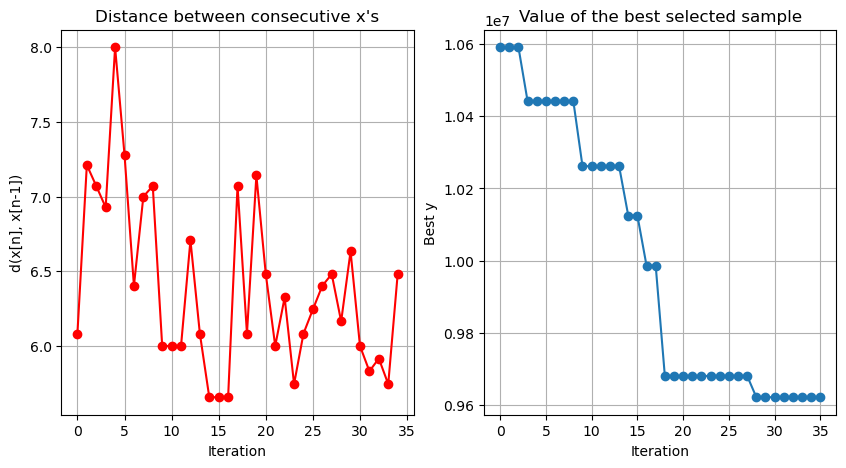

In [21]:
bo_rbf45.plot_convergence()

In [22]:
print(bo_rbf45.x_opt)
print(bo_rbf45.fx_opt)

[0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 1. 0. 0.]
9622186.300506027


## RBF kernel 50

In [11]:
# Budget constraint function
def budget_constraint(x):
    return sum(x[:, e] for e in range(100)) - 50

constraint_string = constraint_to_string(budget_constraint)
constraints50 = [{'name': 'budget_con', 'constraint': constraint_string}]

In [12]:
start_time = datetime.fromtimestamp(time.time())

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space=bounds, constraints=constraints50) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True, optimize_restarts=5, verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Create BO object
bo_rbf50 = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

# Run the optimization                                                  
bo_rbf50.run_optimization(max_iter=max_iter, max_time=max_time, eps=tolerance, verbosity=False) 

end_time = datetime.fromtimestamp(time.time())
print('Total time for rbf kernel 50 edges: ', end_time - start_time)

[[0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1.
  1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.
  1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1.
  0. 0. 0. 0.]]
[[1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.
  0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0.
  0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0.
  1. 1. 0. 0.]]
[[0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1.
  1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0.
  0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1.
  1. 1. 1. 0.]]
[[0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1.

[[1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.
  0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
  1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
  1. 1. 0. 1.]]
[[1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1.
  0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
  1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
  0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
  1. 1. 0. 1.]]
[[1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.
  0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1.
  1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
  0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0.
  1. 1. 0. 0.]]
Total time for rbf kernel 50 edges:  0:20:19.927866


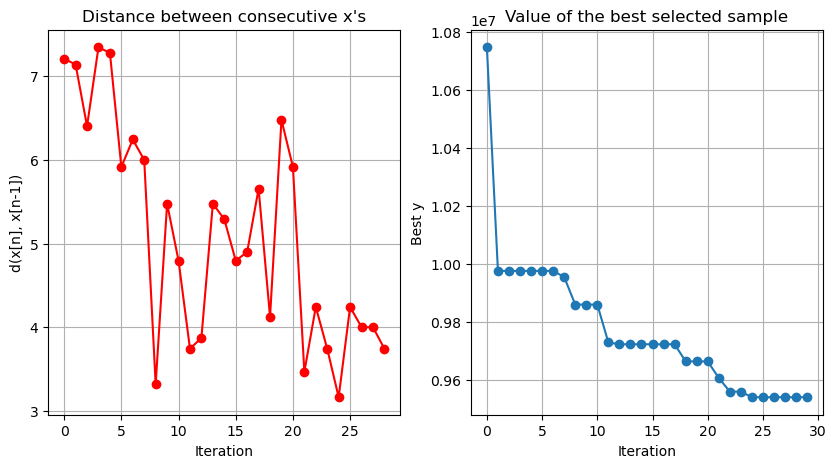

In [16]:
bo_rbf50.plot_convergence()

In [17]:
print(bo_rbf50.x_opt)
print(bo_rbf50.fx_opt)

[1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1.]
9540403.369231412


In [ ]:
print("Selected edges for 30 = ", bo_rbf30.x_opt,
      "\nSelected edges for 35 = ", bo_rbf35.x_opt,
      "\nSelected edges for 40 = ", bo_rbf40.x_opt,
      "\nSelected edges for 45 = ", bo_rbf45.x_opt,
      "\nSelected edges for 50 = ", bo_rbf50.x_opt,
      "\nBayesian optimization function for 30 = ", bo_rbf30.fx_opt,
      "\nBayesian optimization function for 35 = ", bo_rbf35.fx_opt,
      "\nBayesian optimization function for 40 = ", bo_rbf40.fx_opt,
      "\nBayesian optimization function for 45 = ", bo_rbf45.fx_opt,
      "\nBayesian optimization function for 50 = ", bo_rbf50.fx_opt)

In [ ]:
bayesian_optimization = [bo_rbf30.fx_opt, bo_rbf35.fx_opt, bo_rbf40.fx_opt, bo_rbf45.fx_opt, bo_rbf50.fx_opt]
colors = ['red', 'orange', 'purple', 'blue', 'green']
selectedEdges = [30, 35, 40, 45, 50]

In [18]:
# Bayesian Optimization for Siouxfalls without dim kernel, 100 iteration (02-siouxfallsbilevel-Paper-Default-Kernel-100Iter)
bo_rbf30_iter100 = 10346082.63 # Total time for rbf kernel 30 edges:  0:25:06.762174
bo_rbf35_iter100 = 10063644.56 # Total time for rbf kernel 35 edges:  0:19:45.891599
bo_rbf40_iter100 = 9883833.02  # Total time for rbf kernel 40 edges:  0:19:21.848808
bo_rbf45_iter100 = 9622186.30  # Total time for rbf kernel 45 edges:  0:19:23.167781
bo_rbf50_iter100 = 9540403.36  # Total time for rbf kernel 50 edges:  0:20:19.927866
# Bayesian optimization function for 50 =  9754758.44 Total time for rbf kernel 50 edges:  0:29:27.131915
# Bayesian optimization function for 50 =  9757423.04 Total time for rbf kernel 50 edges:  0:20:22.331608
# Bayesian optimization function for 50 =  9998726.83 Total time for rbf kernel 50 edges:  0:05:35.069361
# Bayesian optimization function for 50 =  9540403.36 Total time for rbf kernel 50 edges:  0:20:19.927866
bayesian_optimization = [bo_rbf30_iter100, bo_rbf35_iter100, bo_rbf40_iter100, bo_rbf45_iter100, bo_rbf50_iter100]
colors = ['red', 'orange', 'purple', 'blue', 'green']
selectedEdges = [30, 35, 40, 45, 50]

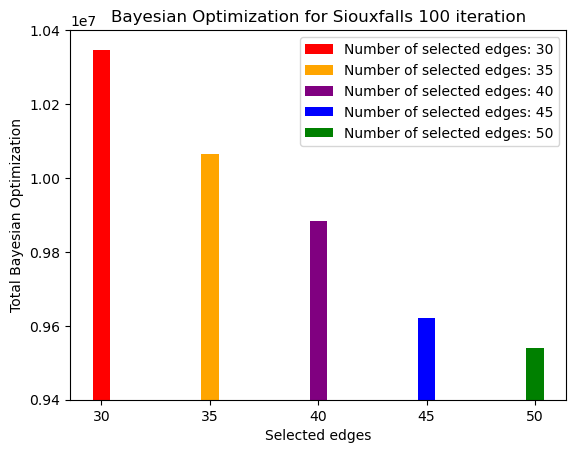

In [19]:
plt.ylim(min(min(bayesian_optimization), 9400000), max(max(bayesian_optimization), 10400000))

for i, (selectedEdges, bo_value) in enumerate(zip(selectedEdges, bayesian_optimization)):
    plt.bar(selectedEdges, bo_value, color=colors[i], label=f'Number of selected edges: {selectedEdges}')
    
plt.xlabel('Selected edges')
plt.ylabel('Total Bayesian Optimization')
plt.title('Bayesian Optimization for Siouxfalls 100 iteration')
plt.legend()
plt.show()